In [2]:
import spacy
import random
from collections import Counter #for counting
import seaborn as sns #for visualization
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn')
sns.set(font_scale=2)
import json
import pyLDAvis.sklearn
import pyLDAvis

In [3]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.0.0/en_core_web_lg-3.0.0.tar.gz --user
#!python -m spacy download en_core_web_lg 
nlp = spacy.load('en_core_web_lg')
# python -m spacy download en_vectors_web_lg

In [4]:
reviews = pd.read_csv("review.csv")
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93503 entries, 0 to 93502
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rating       93503 non-null  float64
 1   Date         90890 non-null  object 
 2   Review_Text  93503 non-null  object 
 3   Branch       93503 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.9+ MB


In [5]:
reviews.head(10)

,Rating,Date,Review_Text,Branch
0,4.0,2019-04-01,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4.0,2019-05-01,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4.0,2019-04-01,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4.0,2019-04-01,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4.0,2019-04-01,"the location is not in the city, took around 1...",Disneyland_HongKong
5,3.0,2019-04-01,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
6,5.0,2019-04-01,Great place! Your day will go by and you won't...,Disneyland_HongKong
7,3.0,2019-03-01,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
8,2.0,2019-04-01,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong
9,5.0,2019-03-01,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong


In [6]:
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string
from tqdm import tqdm

In [7]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [8]:
reviews['Branch'].unique()

array(['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris',
       'Universal Studios Florida', 'Universal Studios Japan',
       'Universal Studios Singapore'], dtype=object)

In [9]:
disney = reviews[reviews['Branch'].str[0]=='D']
disney

,Rating,Date,Review_Text,Branch
0,4.0,2019-04-01,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4.0,2019-05-01,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4.0,2019-04-01,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4.0,2019-04-01,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4.0,2019-04-01,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...
42639,5.0,NaN,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42640,5.0,NaN,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42641,5.0,NaN,My eleven year old daughter and myself went to...,Disneyland_Paris
42642,4.0,NaN,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


In [10]:
universal = reviews[reviews['Branch'].str[0]=='U']
universal

,Rating,Date,Review_Text,Branch
42644,2.0,2021-05-30,We went to Universal over Memorial Day weekend...,Universal Studios Florida
42645,1.0,2021-05-30,The food service is horrible. I’m not reviewin...,Universal Studios Florida
42646,2.0,2021-05-30,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
42647,4.0,2021-05-29,When a person tries the test seat for the ride...,Universal Studios Florida
42648,5.0,2021-05-28,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida
...,...,...,...,...
93498,4.0,2010-03-29,This is my first visit to a Universal Studio t...,Universal Studios Singapore
93499,4.0,2010-03-29,We finally visited Singapore's very first them...,Universal Studios Singapore
93500,4.0,2010-03-28,We visited during the first week of its 'soft ...,Universal Studios Singapore
93501,4.0,2010-03-22,We visited on the 3rd day of the 'soft' openin...,Universal Studios Singapore


In [11]:
reviews['Review_Text'] = reviews['Review_Text'].str.lower()
def remove_punctuation(text):
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)

# Remove punctuation from the review heading and review body columns
reviews['Review_Text'] = reviews['Review_Text'].apply(remove_punctuation)
reviews.head()

,Rating,Date,Review_Text,Branch
0,4.0,2019-04-01,if youve ever been to disneyland anywhere youl...,Disneyland_HongKong
1,4.0,2019-05-01,its been a while since d last time we visit hk...,Disneyland_HongKong
2,4.0,2019-04-01,thanks god it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4.0,2019-04-01,hk disneyland is a great compact park unfortun...,Disneyland_HongKong
4,4.0,2019-04-01,the location is not in the city took around 1 ...,Disneyland_HongKong


pip install textblob

In [12]:
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import spacy
import nltk

# Task 1: Tokenization

# Create empty lists to store the tokenized reviews
nltk_tokens_reviews = []

for row in reviews.iterrows():

    # Get the review heading and review body from the current row
    review = row[1]['Review_Text']

    # Tokenize the review using NLTK
    nltk_tokens_reviews.append(word_tokenize(review))

# Add the tokenized reviews as new columns to the DataFrame
reviews['nltk_tokens_reviews'] = nltk_tokens_reviews

# Task 2: Stop Words Removal
# Load the list of stop words
stop_words = nltk.corpus.stopwords.words("english")

# Function to remove stop words from text
def remove_stopwords(text):
    text = [word for word in text if word not in stop_words]
    return text

# Apply remove_stopwords() function to 'nltk_tokens_heading' and 'nltk_tokens_body'
reviews['Review_Text_processed'] = reviews['nltk_tokens_reviews'].apply(remove_stopwords)
reviews.head()

,Rating,Date,Review_Text,Branch,nltk_tokens_reviews,Review_Text_processed
0,4.0,2019-04-01,if youve ever been to disneyland anywhere youl...,Disneyland_HongKong,"[if, youve, ever, been, to, disneyland, anywhe...","[youve, ever, disneyland, anywhere, youll, fin..."
1,4.0,2019-05-01,its been a while since d last time we visit hk...,Disneyland_HongKong,"[its, been, a, while, since, d, last, time, we...","[since, last, time, visit, hk, disneyland, yet..."
2,4.0,2019-04-01,thanks god it wasn t too hot or too humid wh...,Disneyland_HongKong,"[thanks, god, it, wasn, t, too, hot, or, too, ...","[thanks, god, hot, humid, visiting, park, othe..."
3,4.0,2019-04-01,hk disneyland is a great compact park unfortun...,Disneyland_HongKong,"[hk, disneyland, is, a, great, compact, park, ...","[hk, disneyland, great, compact, park, unfortu..."
4,4.0,2019-04-01,the location is not in the city took around 1 ...,Disneyland_HongKong,"[the, location, is, not, in, the, city, took, ...","[location, city, took, around, 1, hour, kowlon..."


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
# Creating a vectorizer
reviews['Review_Text_processed_str'] = reviews['Review_Text_processed'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(min_df=5,max_df=0.8,stop_words="english",lowercase=True,token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(reviews['Review_Text_processed_str'])

<>:4: DeprecationWarning: invalid escape sequence \-
<>:4: DeprecationWarning: invalid escape sequence \-
<>:4: DeprecationWarning: invalid escape sequence \-
<ipython-input-13-acb08e8b77af>:4: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5,max_df=0.8,stop_words="english",lowercase=True,token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')


In [14]:
# determine the optimal number of topics
from gensim.corpora.dictionary import Dictionary
processed_docs = reviews['Review_Text_processed']
id2word = Dictionary(processed_docs)
id2word.filter_extremes(no_below=5, no_above=0.8)
corpus = [id2word.doc2bow(doc) for doc in processed_docs]

C:\Users\lenovo\.conda\envs\py36\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


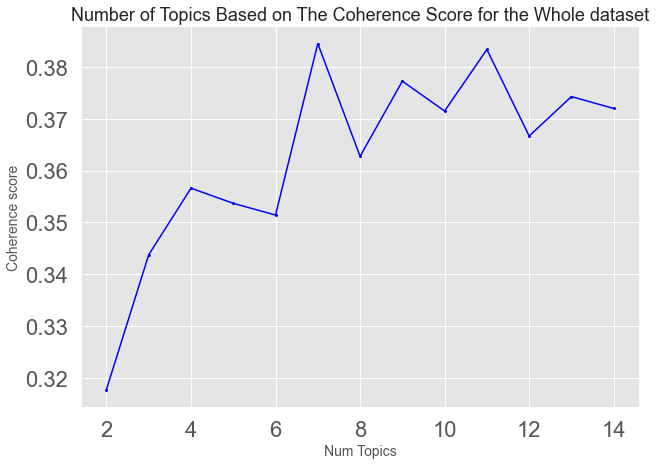

In [15]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import gensim

def compute_coherence_values(dictionary, corpus, texts, start, stop):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                              num_topics=num_topics,
                                              id2word=id2word,
                                              random_state=90,
                                              alpha='auto',
                                              eta='auto',
                                              per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts,
                             dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
start=2
stop=15
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                    corpus=corpus,
                                    texts=reviews['Review_Text_processed'],
                                    start=start, stop=stop)
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(x, coherence_values, color = "blue",marker=".")
plt.xlabel("Num Topics", size=14)
plt.ylabel("Coherence score", size=14)
plt.title('Number of Topics Based on The Coherence Score for the Whole dataset',size=18)
#plt.savefig("output/k_topic.jpg", bbox_inches='tight', dpi = 300)
plt.show()

In [16]:
num_topics = 7

In [17]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [18]:
data_lda

array([[0.00492882, 0.0049487 , 0.70994018, ..., 0.00493432, 0.00498918,
        0.0049507 ],
       [0.00188151, 0.03343128, 0.56586364, ..., 0.02623635, 0.03014399,
        0.10776926],
       [0.00223399, 0.00224013, 0.00224045, ..., 0.04481986, 0.00223822,
        0.00224623],
       ...,
       [0.03715685, 0.02212665, 0.11157088, ..., 0.19215507, 0.02666045,
        0.11679373],
       [0.09863955, 0.03449158, 0.10161168, ..., 0.16327926, 0.00132429,
        0.03163786],
       [0.00072768, 0.05046811, 0.07131846, ..., 0.18847837, 0.12822367,
        0.16191648]])

In [19]:
# Function for printing keywords for each topic
def selected_topics(model,vectorizer,top_n = 10):
    for idx,topic in enumerate(model.components_):
        print("Topic %d:"%(idx))
        print([(vectorizer.get_feature_names()[i],topic[i]) for i in topic.argsort()[:-top_n-1:-1]])

#LDA model
selected_topics(lda,vectorizer)

Topic 0:
[('universal', 45290.421289376354), ('studios', 21406.79248612002), ('singapore', 9664.079868025608), ('express', 7851.867833799096), ('shrek', 5097.940239489095), ('studio', 5001.266987681883), ('experience', 4902.5704563740655), ('orlando', 4656.014514258856), ('alley', 4507.634698854476), ('diagon', 3989.7847863693937)]
Topic 1:
[('harry', 23578.193183465213), ('potter', 23032.29954443883), ('train', 5375.6955381245225), ('hotel', 5062.923611978817), ('world', 4201.232672161438), ('walk', 3468.7303270397383), ('tour', 2670.9757469319284), ('early', 2395.7285548203495), ('journey', 2224.7734658121894), ('usj', 2165.491709325822)]
Topic 2:
[('ride', 52474.78812946758), ('rides', 30850.918209210908), ('park', 25388.273953508215), ('great', 11530.608061026656), ('fun', 11274.440915012932), ('like', 11152.871287466536), ('mummy', 10742.424115555446), ('roller', 10665.76084181091), ('adventure', 9868.752963616163), ('transformers', 9491.855336114788)]
Topic 3:
[('park', 56525.911

pip install pyLDAvis --user

In [20]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda,data_vectorized,vectorizer,mds='tsne',n_jobs=1)
dash

C:\Users\lenovo\.conda\envs\py36\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3     -29.594002  60.112713       1        1  33.303106
4     -45.996586  11.891685       2        1  17.693806
2      20.368856  70.019325       3        1  17.532788
6      53.928768  31.704309       4        1  12.762187
0     -12.437127 -26.423267       5        1   7.310528
1       3.965971  21.797720       6        1   5.928904
5      37.524284 -16.517805       7        1   5.468682, topic_info=              Term          Freq         Total Category  logprob  loglift
16865    universal  40066.000000  40066.000000  Default  30.0000  30.0000
13266         ride  71645.000000  71645.000000  Default  29.0000  29.0000
7190         harry  23309.000000  23309.000000  Default  28.0000  28.0000
11902       potter  22821.000000  22821.000000  Default  27.0000  27.0000
15299      studios  18943.000000  18943.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
14210        shows   2006.415298  11113.786877   Topic7  -4.8754   1.1943
13708          saw   1526.489288   4007.449773   Topic7  -5.1488   1.9409
1091          away   1497.411919   4917.322285   Topic7  -5.1680   1.7171
13130  restaurants   1441.586578   5163.985207   Topic7  -5.2060   1.6302
9585          meal   1255.667934   3175.877141   Topic7  -5.3441   1.9782

[488 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
147        3  0.068386  activities
147        4  0.904294  activities
147        7  0.027222  activities
150        5  0.998886      actors
172        2  0.999033    addition
...      ...       ...         ...
18011      3  0.009086       young
18011      4  0.906800       young
18026      3  0.998708       youve
18031      5  0.997998         yrs
18060      2  0.998677        zone

[975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 7, 1, 2, 6])